In [1]:
url="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [2]:
import tensorflow as tf

In [4]:


dataset= tf.keras.utils.get_file("aclImdb_v1",
                        url,
                        untar=True,
                        cache_dir=".",
                        cache_subdir=" ")

84125825/84125825 [==============================] - 3s 0us/step


In [5]:
import os
dataset_dir=os.path.join(os.path.dirname(dataset),"aclImdb")

In [6]:
os.listdir(dataset_dir) #dosyaları görmek için yazdım

['train', 'imdbEr.txt', 'README', 'test', 'imdb.vocab']

In [7]:
train_dir = os.path.join(dataset_dir,"train") #kalsör dizinini değişkene atadık
os.listdir(train_dir)

['unsup',
 'urls_unsup.txt',
 'labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt']

In [8]:
sample_file = os.path.join(train_dir,"pos/1181_9.txt")
with open(sample_file) as f:   #dosyayı okuduk burada
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [9]:
##klasör kaldırma işlemi
remove_dir = os.path.join(train_dir,"unsup")
import shutil
shutil.rmtree(remove_dir)   #dosyayı sildik

In [10]:
##Veri Yükleme aşaması
batch_size = 32 ##verileri 32li gruplar halinde alıyoruz
seed=42 #rastgele seçilen değerler için kullanırız
raw_train_ds=tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2, #doğrulama verisi
    subset="training",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [11]:
import numpy as np
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])   ###3 yorum için metin ve etiketleri aldık

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [12]:
raw_val_ds=tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)       ##validasyon verisini oluşturdum

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
test_dir = os.path.join(dataset_dir, "test")
raw_test_ds=tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size
)       #test veri seti oluşturuldu

Found 25000 files belonging to 2 classes.


In [14]:
###  Veri Ön İşleme ###
import re
import string
def custom_standardization(input_data): #veri setini temizlemeye çalışıyoruz
  lowercase=tf.strings.lower(input_data)
  stripped_html=tf.strings.regex_replace(lowercase,'<br />','')
  return tf.strings.regex_replace(stripped_html,'[%s]'% re.escape(string.punctuation),'')


In [15]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_features = 10000
sequence_length = 250
vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = "int", # tam sayı göstersin diye yaptık
    output_sequence_length=sequence_length
)
     

In [18]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
#metin içeren

In [19]:
def vectorize_text(text, label):
  text=tf.expand_dims(text,-1)
  return vectorize_layer(text),label
     

In [20]:
text_batch, label_batch = next(iter(raw_train_ds)) #metinleri ve etiketleri barındıran değişenleri oluşturduk

In [22]:
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Every scene was put together perfectly.This movie had a wonderful cast and crew. I mean, how can you have a bad movie with Robert Downey Jr. in it,none have and ever will exist. He has the ability to brighten up any movie with his amazing talent.This movie was perfect! I saw this movie sitting all alone on a movie shelf in "Blockbuster" and like it was calling out to me,I couldn\'t resist picking it up and bringing it home with me. You can call me a sappy romantic, but this movie just touched my heart, not to mention made me laugh with pleasure at the same time. Even though it made me cry,I admit, at the end, the whole movie just brightened up my outlook on life thereafter.I suggested to my horror, action, and pure humor movie buff of a brother,who absolutely adored this movie. This is a movie with a good sense of feeling.It could make you laugh out loud, touch your heart, make you fall in love,and enjoy your life.Every time you purposefully walk past this movie, jus

In [24]:
print("128 -->",vectorize_layer.get_vocabulary()[128]) #128. kelimeye karşılık gelen değeri çağırdık
print("1312 -->",vectorize_layer.get_vocabulary()[1312])
print("Vocabulary size: {}" .format(len(vectorize_layer.get_vocabulary())))
#en son kelime sayısını aldık

128 --> these
1312 --> makeup
Vocabulary size: 10000


In [25]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [26]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE) #prefesh veri ön işleme ve model uygulamayı birlikte yapar

In [27]:
embedding_dim = 16
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features +1, embedding_dim),
  tf.keras.layers.Dropout(0.2), #çıktıların %20sini sildik, düzleştirme yaptık.
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)                     
])
#modeli kuracağız 

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [29]:
#Modeli derleme aşaması
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = "adam",
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0)           
)

In [30]:
#Modelin eğitim aşaması
epochs=10
histroy=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 61s 90ms/step - loss: 0.6673 - binary_accuracy: 0.6808 - val_loss: 0.6218 - val_binary_accuracy: 0.7708
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5559 - binary_accuracy: 0.7979 - val_loss: 0.5056 - val_binary_accuracy: 0.8202
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4520 - binary_accuracy: 0.8416 - val_loss: 0.4270 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3851 - binary_accuracy: 0.8619 - val_loss: 0.3797 - val_binary_accuracy: 0.8590
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3417 - binary_accuracy: 0.8754 - val_loss: 0.3506 - val_binary_accuracy: 0.8666
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3114 - binary_accuracy: 0.8852 - val_loss: 0.3314 - val_binary_accuracy: 0.8706
Epoch 7/10
625/625 [==============================] - 3s 4ms/s

In [31]:
#Modelin performansını değerlendireceğiz 
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3145 - binary_accuracy: 0.8712
Loss:  0.31448790431022644
Accuracy:  0.8712400197982788


In [33]:
history_dict=histroy.history
history_dict.keys()

#loss ve accuracy grafiğini çizdireceğim aşağıda

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [34]:
import matplotlib.pyplot as plt
acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

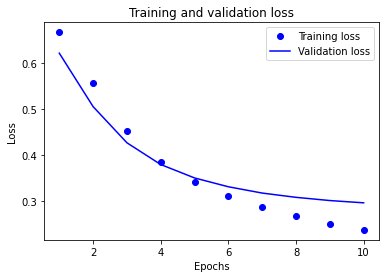

In [35]:
epochs = range(1,len(acc)+1)
plt.plot(epochs, loss, "bo", label="Training loss") #loss grafiği
plt.plot(epochs, val_loss, "b", label="Validation loss") #validasyon loss grafiği
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

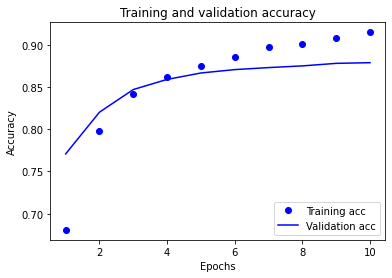

In [36]:
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

#yine aynı mantık bu sefer loss değil accuracy grafiği çizdirdim

In [37]:
#Model overfitting oldu, ezber yaptı, bunu düzeltmemiz lazım
export_model = tf.keras.Sequential([
                                    vectorize_layer,
                                    model,
                                    tf.keras.layers.Activation("sigmoid")
])

In [38]:
export_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                     optimizer = "adam",
                     metrics=["accuracy"])

In [39]:
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3145 - accuracy: 0.8712
0.8712400197982788


In [40]:
#Yeni verileri tahmin edicez
examples = [
            "The movie was perfect",
            "The movie was okay",
            "The movie was awful"
]

In [42]:
export_model.predict(examples) #0.5den büyükse pozitif duygu, değilse negatif duygu

1/1 [==============================] - 0s 36ms/step


array([[0.6286795],
       [0.4477523],
       [0.3352925]], dtype=float32)